<a href="https://colab.research.google.com/github/ochekroun/projet-ia/blob/master/classification-images/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras import layers
from keras.applications import EfficientNetB0
import requests
import tarfile
import os
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import learning_curve
import json
#from torch.utils.data import Dataset
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
#from torch.utils.data import DataLoader
from pathlib import Path

### Téléchargements : 
- images
- annotations
- labels

In [ ]:
%%time
# Wall time: 20min 7s Google Colab
download_file = False

Path("./data").mkdir(parents=True, exist_ok=True)

if download_file:
    def decompress(tar_file, file_path, members=None):
        """
        Extracts `tar_file` and puts the `members` to `path`.
        If members is None, all members on `tar_file` will be extracted.
        """
        tar = tarfile.open(tar_file, mode="r:gz")
        if members is None:
            members = tar.getmembers()
        # with progress bar
        # set the progress bar
        progress = tqdm(members)
        for member in progress:
            tar.extract(member, path=file_path)
            # set the progress description of the progress bar
            progress.set_description(f"Extracting {member.name}")

        tar.close()

    def download(url, file_path):
        # Streaming, so we can iterate over the response.
        response = requests.get(url, stream=True)

        # Sizes in bytes.
        total_size = int(response.headers.get("content-length", 0))
        block_size = 4096

        with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
            with open(file_path, "wb") as file:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)

        if total_size != 0 and progress_bar.n != total_size:
            raise RuntimeError("Could not download file")


    download('https://olivierchekroun.blob.core.windows.net/documents/projet-ia/nus_wide.tar.gz','./data/nus_wide.tar.gz')
    decompress('./data/nus_wide.tar.gz', './data/nuswide_81')
    
    download('https://olivierchekroun.blob.core.windows.net/documents/projet-ia/data.tar.gz','./data/data.tar.gz')
    decompress('./data/data.tar.gz', './data/')



check_image_file = False
if check_image_file:
    image_dir = './data/images'
    bad_image_file_path = './data/bad_images.txt'
    IMG_SIZE = 224
    size = (IMG_SIZE, IMG_SIZE)
    count = 0
    try:
        os.remove(bad_image_file_path)
    except OSError:
        pass
    arr = os.listdir(image_dir)
    print(len(arr))
    bad_files = []
    for image_name in tqdm(arr):
        count += 1
        imagePath = os.path.join(image_dir, image_name)
        try:
            image = Image.open(imagePath)
            image.load()
            image = tf.image.resize(image, size)
            image = image.numpy()
        except Exception as e:
            print(f'{e} {imagePath}')
            bad_files.append(image_name)
            continue
    print(f'Images count: {count}')

    print(bad_files)

    with open(bad_image_file_path, 'w') as f:
        for line in bad_files:
            f.write(f"{line}\n")

### Chargement des données brutes

In [ ]:
def load_labels():
    labels = []
    with open('./data/labels.txt') as f:
        lines = f.read().splitlines()
        for line in lines:
            labels.append(line)
    return labels

def load_dataframe(file_name):
    with open('./data/bad_images.txt', 'r') as file:
        bad_files = file.read().splitlines()

    print(f'Bad files {bad_files}')

    labels = load_labels()

    # Étape 1 : Charger la liste des images
    with open(file_name) as f:
        all_samples_data = f.read().splitlines()

    image_names =[]
    given_labels = []
    for data_line in tqdm(all_samples_data):
        parts = data_line.split(' ')
        image_name = parts[0]
        array_value = np.asarray(list(map(int, parts[1:])))
        given_label = np.array(labels)[np.argwhere(array_value)[:, 0]]
        image_names.append(image_name)
        given_labels.append(given_label)

    # Étape 3 : Créer le DataFrame
    data = {'image': image_names, 'labels': given_labels}
    df = pd.DataFrame(data)
    print(f'Dataframe length: {len(df)}')

    # Étape 4 : Exclure les lignes où il n'y a que des 0 dans les tableaux de valeurs
    df_filtered = df
    df_filtered = df[df['labels'].apply(lambda x: any(x))]
    
    # Étape 5 : Exclure les lignes où les images sont corrompues
    df_filtered = df_filtered[~df_filtered['image'].isin(bad_files)]

    print(f'Dataframe filtered length: {len(df_filtered)}')

    return df_filtered

In [ ]:
df = load_dataframe('./data/database.txt')

### Histogramme des données brutes

In [ ]:
label_freq = df['labels'].apply(lambda x: x).explode().value_counts().sort_values(ascending=False)
# Création de l'histogramme horizontal par ordre décroissant et plus grand
plt.figure(figsize=(12, 20))
label_freq.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Frequency')
plt.ylabel('Labels')
plt.title('Frequency of Labels')
plt.show()


# # # Create a list of rare labels
# rare = list(label_freq[label_freq<1000].index)

# # #rare = []

# # print("We will be ignoring these rare labels:", rare)
# labels = load_labels()
# classes = [x for x in labels if x not in rare ]
# # print(classes)

# print(len(rare))
# print(len(classes))


### Nettoyages des données et stratification
 Dataset :
 - train
 - val
 - test

In [ ]:
df['stratify_label'] = df['labels'].apply(lambda x: '|'.join(x))
labels_count = df['stratify_label'].value_counts()
valid_labels = labels_count[labels_count >= 100].index
df_filtered = df[df['stratify_label'].isin(valid_labels)]

print(len(df))
print(len(df_filtered))

In [ ]:
# Transformer les listes en lignes individuelles
exploded_df = df_filtered.explode('labels')

# Obtenir les labels distincts
unique_labels = exploded_df['labels'].unique()
classes = unique_labels
print(unique_labels)
print(len(unique_labels))

In [ ]:
def custom_train_test_split(df, stratify_column, train_samples):
    # Create initial train set of fixed number of samples
    X_train, X_temp = train_test_split(
        df, train_size=train_samples, stratify=df[stratify_column], random_state=42
    )
    
    # Calculate the size of validation set (0.2% of train size)
    val_size = int(0.1 * train_samples)
    
    # Create the validation set from the remaining data
    X_val, X_temp,  = train_test_split(
        X_temp, test_size=(len(X_temp) - val_size), stratify=X_temp[stratify_column], random_state=42
    )
    
    # Calculate the size of test set (50% of validation size)
    #test_size = int(0.5 * val_size)
    test_size = val_size
    
    # Create the test set from the remaining data
    X_test, X_unused = train_test_split(
        X_temp, test_size=(len(X_temp) - test_size), stratify=X_temp[stratify_column], random_state=42
    )
    
    return X_train, X_val, X_test


In [ ]:
# Example usage:
# X, y are your features and target DataFrame respectively
# stratify_column is the name of the column in y used for stratification
# train_samples is the fixed number of samples for the train set

X_train, X_val, X_test = custom_train_test_split(df_filtered, 'stratify_label', 10000)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

In [ ]:
def write_df(df, labels, file_path):
    rows = []
    for index, row in df[['image', 'labels']].iterrows():
        row_image = row['image']
        row_labels = row['labels'].tolist()
        row = {'image_name': row_image, 'image_labels': row_labels}
        rows.append(row)
    with open(file_path, 'w') as fp:
        json.dump({'samples': rows, 'labels': labels.tolist()}, fp, indent=3)

write_df(X_train, classes, './data/train.json')
write_df(X_val, classes, './data/val.json')
write_df(X_test, classes, './data/test.json')

### Création d'une classe pour le chargement des données

In [ ]:
class CustomDataset(keras.utils.Sequence):
    def __init__(self, file_path, batch_size=1, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.image_size = (224, 224)
        self.shuffle = shuffle


        with open(file_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']
        self.num_classes = len(self.classes)

        self.imgs = []
        self.vectors = []
        self.labels = []
        print('loading', file_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            labels = sample['image_labels']
            self.labels.append(labels)

            vector = [cls in labels for cls in self.classes]
            self.vectors.append(np.array(vector, dtype=float))

        self.on_epoch_end()
        


    def __len__(self):
        return int(np.floor(len(self.imgs) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_filenames = [self.imgs[k] for k in indices]
        batch_labels = [self.vectors[k] for k in indices]

        X, y = self.__data_generation(batch_filenames, batch_labels)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.imgs))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_filenames, batch_labels):
        X = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, self.num_classes), dtype=int)

        for i, (filename, label) in enumerate(zip(batch_filenames, batch_labels)):
            image = Image.open(filename).resize(self.image_size)
            image = np.array(image)
            if image.shape == (self.image_size[0], self.image_size[1], 3):  # Check if image is RGB
                #image = preprocess_input(image)
                X[i,] = image
                y[i] = label

        return X, y
    
    def image_labels(self, idx):
        img_labels = self.labels[idx]
        img_path = self.imgs[idx]
        image = Image.open(img_path)
        return image, img_labels

### Dataset stratifiées

In [ ]:
batch_size = 32
train_ds = CustomDataset('./data/train.json', batch_size=batch_size)
val_ds = CustomDataset('./data/val.json', batch_size=batch_size)
test_ds = CustomDataset('./data/test.json', batch_size=batch_size)

def show_histo_matplotlib(title, dataset, ax):
    samples = dataset.vectors
    samples = np.array(samples)
    class_counts = np.sum(samples, axis=0)
    sorted_ids = np.array([i[0] for i in sorted(enumerate(class_counts), key=lambda x: x[1])], dtype=int)
    ax.barh(range(len(dataset.classes)), width=class_counts[sorted_ids])
    ax.set_yticks(range(len(dataset.classes)))
    ax.set_yticklabels(np.array(dataset.classes)[sorted_ids])
    ax.margins(y=0)
    ax.grid()
    ax.set_title(title)

# Créer une figure avec 1 ligne et 3 colonnes
fig, axes = plt.subplots(1, 3, figsize=(18, 12))

# Premier histogramme
show_histo_matplotlib('Train', train_ds, axes[0])

# Deuxième histogramme
show_histo_matplotlib('Validation', val_ds, axes[1])

# Troisième histogramme
show_histo_matplotlib('Test', test_ds, axes[2])

# Ajouter un titre global
fig.suptitle('Dataset stratifiées')

# Afficher la figure
plt.show()

### Exemples d'images avec labels

In [ ]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
for idx in range(5):
    img, labels = train_ds.image_labels(idx)
    plt.imshow(img)
    plt.title("{}".format(', '.join(labels)))
    plt.axis('off')
    plt.show()

### Modèle
- Création à partir de EfficientNetB0
- Entraînement
- Evaluation

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))

    # On retire les dernières couches avec "include_top=False"
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # "Glace" the paramètres pré-entrainés
    model.trainable = False

    # On rajoute les couches retirées - ces couches sont entrainables !
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)

    # On peut ajuster le ratio de neurones désactivés pour la couche Dropout
    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation='sigmoid', name="predictions")(x)

    # Compile le nouveau modèle
    model = keras.Model(inputs, outputs, name="EfficientNet")

    # On augmente le learning rate du défaut 0.001 à 0.01
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
         optimizer=optimizer,
         loss=tf.keras.metrics.binary_crossentropy,
         metrics=["binary_accuracy"]
    )
    return model

In [ ]:
model = build_model(len(classes))
history = model.fit(x=train_ds, validation_data=val_ds, epochs=1)
model.save('simple_model_without_unfreeze.keras')

In [ ]:
model.evaluate(x=test_ds)

In [ ]:
# Retrieve data from the history
loss = history.history['loss']
val_loss = history.history['val_loss']
binary_accuracy = history.history['binary_accuracy']
val_binary_accuracy = history.history['val_binary_accuracy']

# Plot the loss curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(binary_accuracy, label='Training Accuracy')
plt.plot(val_binary_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
### Prédictions

In [33]:
def predictions(k, threshold, image, model, classes):
    def image_processing(image):
        IMG_SIZE = 224
        size = (IMG_SIZE, IMG_SIZE)    
        image = tf.image.resize(image, size)
        image = image.numpy()
        return image    
    # Assurez-vous que l'image est correctement chargée et traitée
    test_img = image_processing(image)  # Correction: Utiliser image_path au lieu de image
    test_img = np.expand_dims(test_img, axis=0)
    
    # Obtenir les prédictions brutes du modèle
    raw_pred = model(test_img, training=False).cpu().numpy()[0]
    
    # Obtenir les indices des k meilleures prédictions
    top_indices = np.argsort(raw_pred)[-k:][::-1]
    
    # Obtenir les étiquettes prédites pour les k meilleures prédictions
    topk_labels = np.array(classes)[top_indices]
    
    # Appliquer le seuil pour obtenir les indices des prédictions qui dépassent le seuil
    threshold_indices = raw_pred > threshold
    threshold_labels = np.array(classes)[np.where(threshold_indices)]
    all_labels = set(topk_labels) | set(threshold_labels)

    # Si aucune étiquette n'est prédite (très improbable avec les k meilleures prédictions), définir comme 'aucune prédiction'
    if len(topk_labels) == 0:
        topk_labels = ['No top k predictions']

    # Si aucune étiquette ne dépasse le seuil, définir comme 'aucune prédiction'
    if len(threshold_labels) == 0:
        threshold_labels = ['No threshold predictions']
        
    return topk_labels, threshold_labels, all_labels

def plot_predictions(topk, treshold, topk_predictions, treshold_predictions, image, gt_predictions = []):
    plt.imshow(image)
    title = f'Top{topk}: {topk_predictions}\nTreshold {treshold}{treshold_predictions}\n'
    if(len(gt_predictions)>0):
        title += f'GT {gt_predictions}'
    plt.title(title,fontsize=9)
    plt.axis('off')
    plt.show()

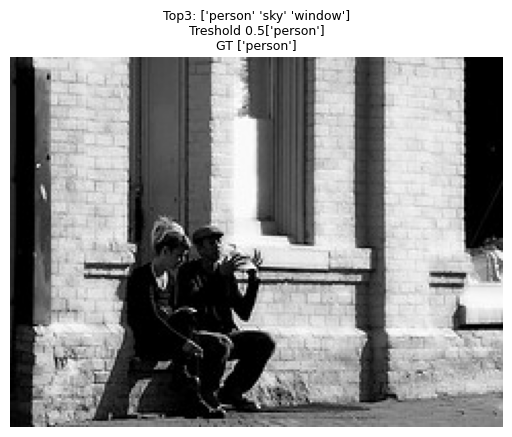

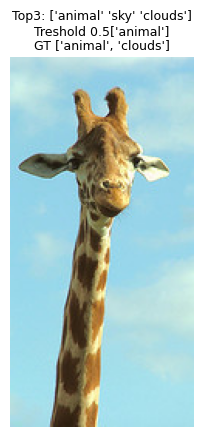

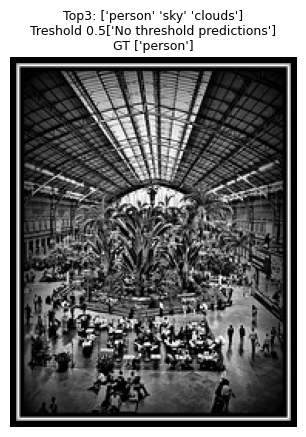

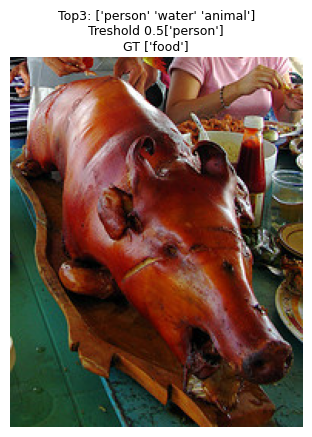

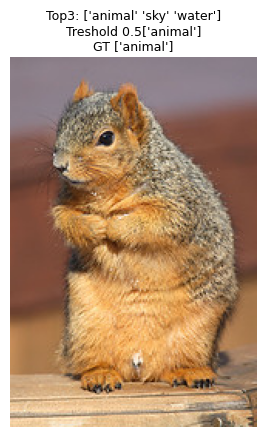

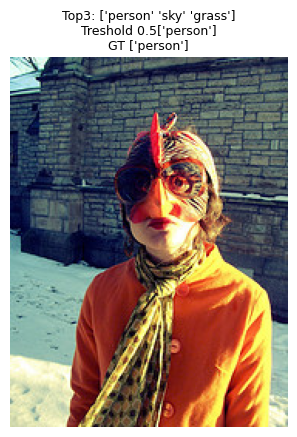

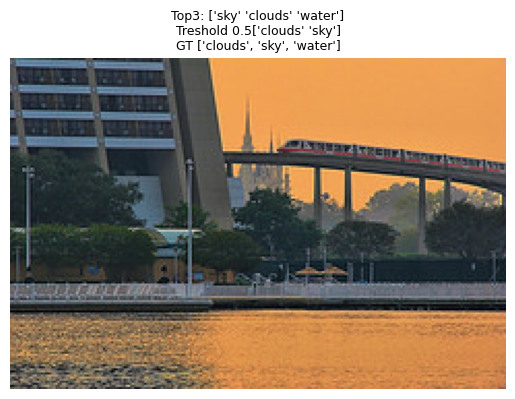

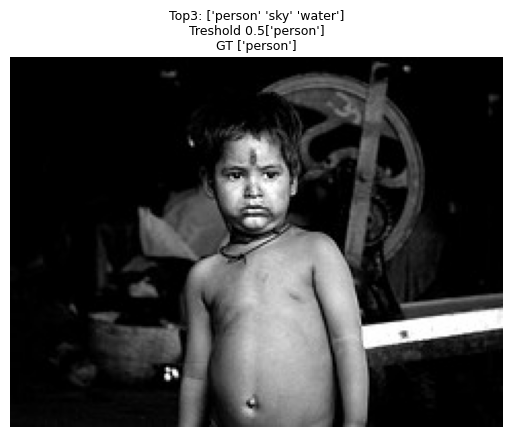

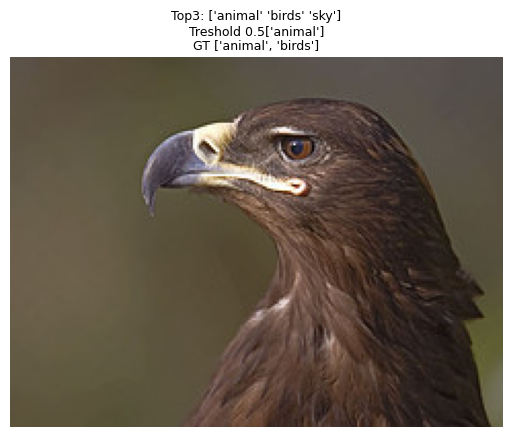

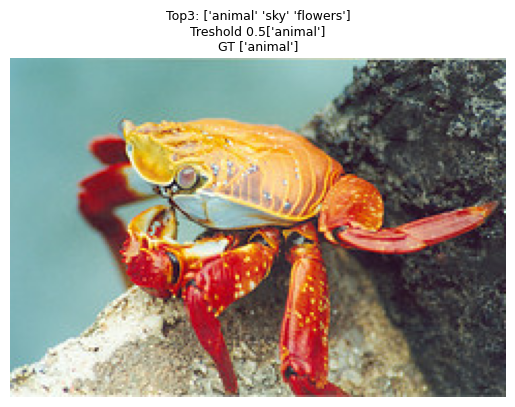

In [34]:
for idx in range(205, 215):
    image, labels = test_ds.image_labels(idx)
    topk_val = 3
    treshold_val = 0.5
    topk, treshold, all = predictions(topk_val, treshold_val, image, model, classes)
    plot_predictions(topk_val, treshold_val, topk, treshold, image, labels)

3
2


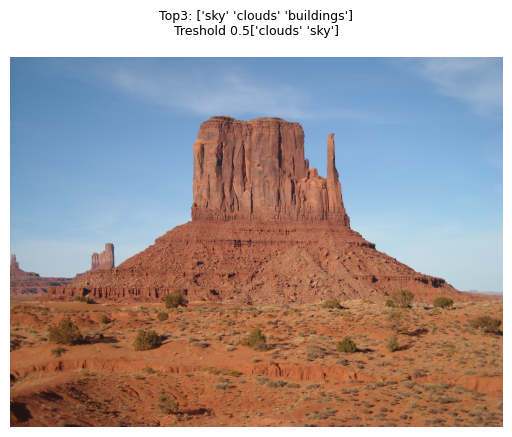

3
1


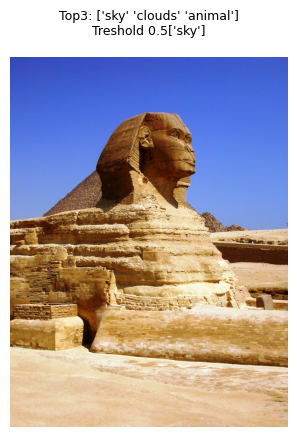

3
2


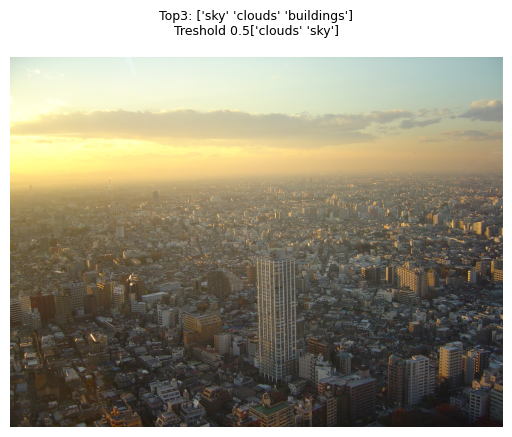

3
1


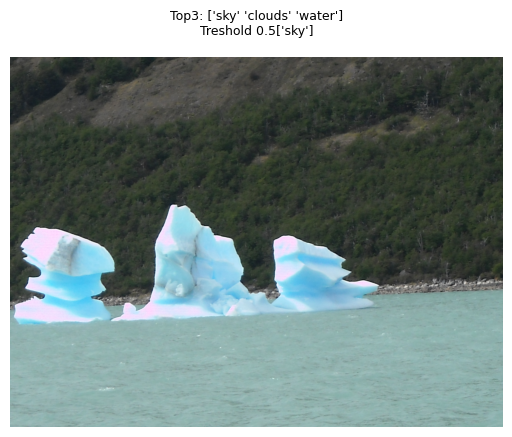

3
2


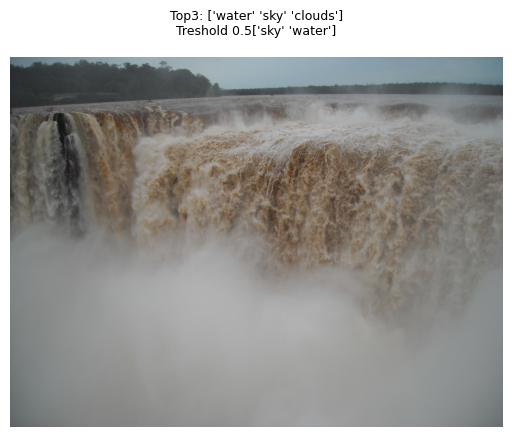

3
1


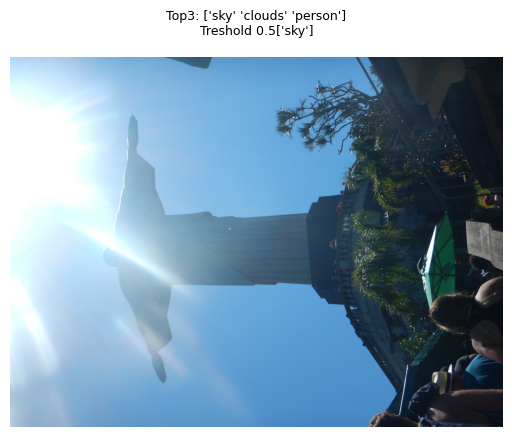

3
0


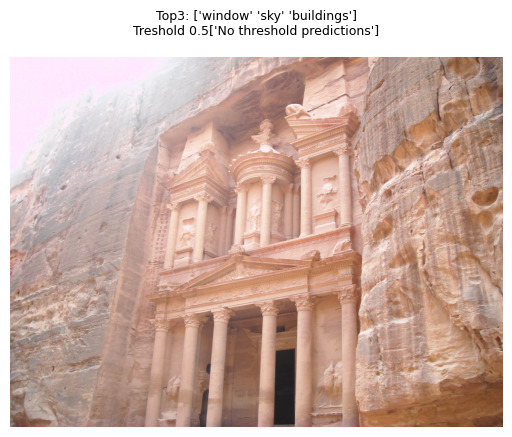

3
1


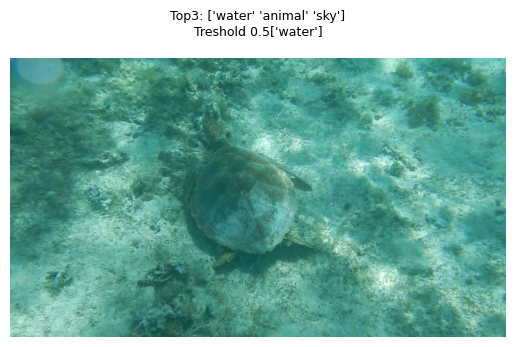

3
0


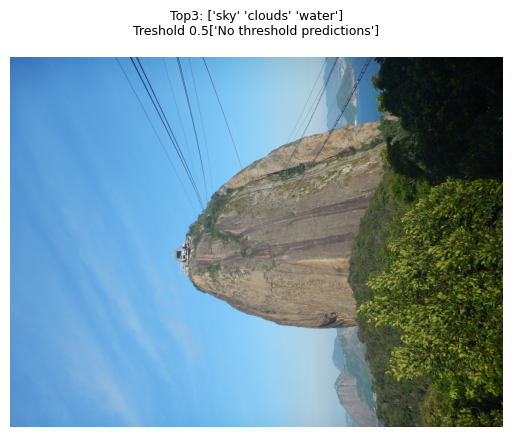

3
0


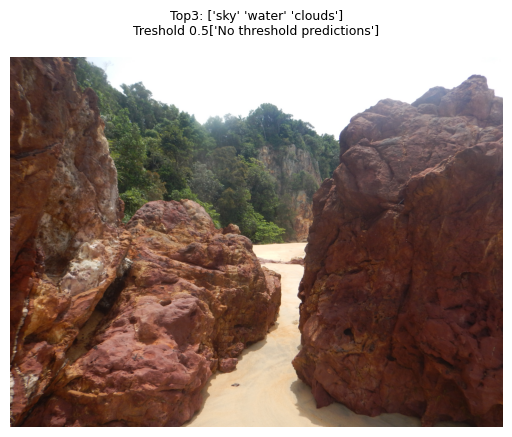

In [31]:
directory_path = './data/images_persos'

Path(directory_path).mkdir(parents=True, exist_ok=True)

# List all files and directories
for entry in os.listdir(directory_path):
    full_path = os.path.join(directory_path, entry)
    if os.path.isfile(full_path):
        image = Image.open(full_path)
        topk_val = 3
        treshold_val = 0.5
        topk, treshold, all = predictions(topk_val, treshold_val, image, model, classes)
        plot_predictions(topk_val, treshold_val, topk, treshold, image)